<a href="https://colab.research.google.com/github/Hello-Nuri/SeoulBike_logistic_optimization_service/blob/main/%5BBidirectional_LSTM%5D%E1%84%87%E1%85%A9%E1%86%B7%E1%84%8B%E1%85%A7%E1%84%85%E1%85%B3%E1%86%B7%E1%84%80%E1%85%A1%E1%84%8B%E1%85%B3%E1%86%AF_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF_1%E1%84%89%E1%85%B5%E1%84%80%E1%85%A1%E1%86%AB%E1%84%8E%E1%85%AE%E1%84%85%E1%85%A9%E1%86%AB_168%EC%8B%9C%EA%B0%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### import

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import re

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#### Hyperparameter Setting

In [ ]:
CFG = {
    # 예측하려는 시점을 X_RANGE 만큼의 이전 일자의 데이터로부터 예측 및 학습
    'X_RANGE':168, # 이경우 이전 168시간 데이터로부터 예측 및 학습
    'EPOCHS':50,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':128,
    'SEED':41
}

#### Fixed RandomSeed






In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

#### Data_Load from google bigquery

In [ ]:
# bigquery 연동하기
from google.oauth2 import service_account
from google.cloud import bigquery

In [ ]:
credentials = service_account.Credentials.from_service_account_file('./credential_key.json')

In [ ]:
credentials

In [ ]:
client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id
)

In [ ]:
client

In [ ]:
# train_set
#학습: 2022년 봄여름가을 데이터, 2023년 봄여름가을 데이터
query = """
SELECT
*
FROM
  `multi-final-project.Final_table_NURI.Rantalcount_timeseries_data_22n23`
"""

In [ ]:
df = client.query(query).to_dataframe()

In [ ]:
# valid_set
#예측: 2024년 3월 데이터
query_24 = """
SELECT *
FROM
`multi-final-project.Final_table_NURI.Rental_count_time_series_data_2403`
"""

In [ ]:
df_24 = client.query(query_24).to_dataframe()

Data_preprocessing(date nomalization)

In [ ]:
df['DAY'] = pd.to_datetime(df['day'])

In [ ]:
df['DAY'] = df['DAY'].dt.strftime('%Y%m%d')

In [ ]:
df_24['DAY'] = pd.to_datetime(df_24['day'])

In [ ]:
df_24['DAY'] = df_24['DAY'].dt.strftime('%Y%m%d')

In [ ]:
def make_ymd_feature(df):
    df['DAY'] = df['DAY'].astype(str) # 일시를 문자열로 반환
    df['YEAR'] = df['DAY'].str[:4].astype(int)/1000. # 년도만 추출하여 숫자형으로 반환, /1000으로 날짜정규화
    df['MONTH'] = df['DAY'].str[4:6].astype(int)/12.  # '20240101'에서 '01'을 추출하고 12로 나누면 0.0833 / 정규화: 월을 12로 나누어 0에서 1 사이의 값으로 변환
    df['DAY'] = df['DAY'].str[6:8].astype(int)/31.  #
    df['HOUR'] = df['hour'].astype(int)/24.
    df = df[['YEAR', 'MONTH', 'DAY','HOUR',"ST_1171",	"ST_1172",	"ST_1173",	"ST_1174",	"ST_1178",	"ST_1179",	"ST_1180",	"ST_1181",	"ST_1182",	"ST_1184",	"ST_1185",	"ST_1186",	"ST_1245",	"ST_1246",	"ST_1247",	"ST_1248",	"ST_1364",	"ST_1365",	"ST_1407",	"ST_1433",	"ST_1559",	"ST_1561",	"ST_1562",	"ST_1566",	"ST_1568",	"ST_1571",	"ST_1573",	"ST_1574",	"ST_1575",	"ST_1576",	"ST_1577",	"ST_1578",	"ST_1679",	"ST_1703",	"ST_777",	"ST_779",	"ST_782",	"ST_783",	"ST_784",	"ST_786",	"ST_787",	"ST_788",	"ST_790",	"ST_791",	"ST_792",	"ST_793",	"ST_794",	"ST_795",	"ST_796",	"ST_798",	"ST_799",	"ST_801",	"ST_802",	"ST_804",	"ST_806",	"ST_807",	"ST_808",	"ST_809",	"ST_810",	"ST_811",	"ST_812",	"ST_813",	"ST_814",	"ST_815",	"ST_816",	"ST_817",	"ST_819",	"ST_820",	"ST_822",	"ST_823",	"ST_937",	"ST_953",	"ST_956",	"ST_957",	"ST_958",	"ST_959",	"ST_960",	"ST_961",	"ST_962",	"ST_963",	"ST_966",	"ST_1560",	"ST_2690",	"ST_2474",	"ST_2788",	"ST_2837",	"ST_2839",	"ST_2868",	"ST_2869",	"ST_2926",	"ST_3078",	"ST_3096",	"ST_3164",	"ST_3179",	"ST_3185",	"ST_2870",	"ST_2927",	"ST_3066",	"ST_3108",	"ST_3109",	"ST_3112",	"ST_3115",	"ST_3178",	"ST_3254",	"ST_1177",	"ST_2684",	"ST_2847",	"ST_2882",	"ST_3111",	"ST_3243",	"ST_3208",	"ST_3207",	"ST_1366",	"ST_1564",	"ST_1680",	"ST_1882",	"ST_1883",	"ST_1884",	"ST_1888",	"ST_1889",	"ST_1892",	"ST_1893",	"ST_1895",	"ST_1896",	"ST_1897",	"ST_2673",	"ST_2675",	"ST_2677",	"ST_2678",	"ST_2679",	"ST_2680",	"ST_2681",	"ST_2682",	"ST_2685",	"ST_2686",	"ST_2688",	"ST_2689",	"ST_2691",	"ST_2838",	"ST_2867",	"ST_2925",	"ST_3077",	"ST_3079",	"ST_3240",	"ST_3245",	"ST_3268",	"ST_789",	"ST_954",	"ST_1885",	"ST_2907",	"ST_1881",	"ST_2671",	"ST_818",	"ST_2674",	"ST_2676",	"ST_821",	"ST_1879",	"ST_1880",	"ST_1886",	"ST_1891",	"ST_797"]]
    return df

In [ ]:
df = make_ymd_feature(df)

In [ ]:
df_24 = make_ymd_feature(df_24)

In [ ]:
#학습: 2022,2023 봄여름가을 데이터 df
train_df = df.reset_index().drop(columns='index')

In [ ]:
#예측: 2024년 3월 데이터
#sequence : 24년 3월 1일~7일 168시간 → 다음 1시간 예측
val_df = df_24.reset_index().drop(columns='index')

In [ ]:
#forecast data 2023 11월20일 0시 ~ 11월 26일 23시
# Since real-time data is not immediately available due to privacy issues, we will use some data from the train set for the forecast set.
df_168hours = train_df[12936:13104]

In [ ]:
df_168hours = df_168hours.assign(YEAR=2.024)

In [ ]:
df_168hours

,YEAR,MONTH,DAY,HOUR,ST_1171,ST_1172,ST_1173,ST_1174,ST_1178,ST_1179,...,ST_2671,ST_818,ST_2674,ST_2676,ST_821,ST_1879,ST_1880,ST_1886,ST_1891,ST_797
12936,2.024,0.916667,0.645161,0.000000,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,1,3
12937,2.024,0.916667,0.645161,0.041667,0,0,1,1,0,4,...,0,0,0,0,0,0,0,0,0,0
12938,2.024,0.916667,0.645161,0.083333,0,0,0,1,0,1,...,1,0,0,0,0,0,1,0,0,0
12939,2.024,0.916667,0.645161,0.125000,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
12940,2.024,0.916667,0.645161,0.166667,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13099,2.024,0.916667,0.838710,0.791667,1,0,2,0,0,1,...,0,0,0,1,1,3,0,1,0,1
13100,2.024,0.916667,0.838710,0.833333,0,1,0,3,1,0,...,0,1,0,0,2,1,1,1,0,0
13101,2.024,0.916667,0.838710,0.875000,0,0,0,0,2,0,...,1,0,0,1,5,0,1,0,0,0
13102,2.024,0.916667,0.838710,0.916667,0,0,0,0,1,0,...,0,4,0,0,3,3,2,0,0,0


LOADING DATA

In [ ]:
def get_x_y_data(df, infer=False):
    # x_range : x일전까지의 데이터를 통해 예측
    x_data = []  # x_data: 모델의 입력으로 사용할 데이터를 저장
    y_data = []  # y_data: 모델이 예측해야 할 목표 값을 저장

    for i in tqdm(range(CFG['X_RANGE'], len(df))):
      #CFG['X_RANGE']: 몇 일 전까지의 데이터를 사용할지를 나타내는 설정 값
      # range(CFG['X_RANGE'], len(df)): CFG['X_RANGE']부터 데이터의 마지막까지 반복
      # 즉, 처음 몇 개의 데이터는 과거 데이터를 사용할 수 없기 때문에 제외
      # tqdm: 반복문의 진행 상황을 시각적으로 표시

        x_data.append(np.array(df.loc[i-CFG['X_RANGE']:i-1, ['YEAR', 'MONTH', 'DAY','HOUR',"ST_1171",	"ST_1172",	"ST_1173",	"ST_1174",	"ST_1178",	"ST_1179",	"ST_1180",	"ST_1181",	"ST_1182",	"ST_1184",	"ST_1185",	"ST_1186",	"ST_1245",	"ST_1246",	"ST_1247",	"ST_1248",	"ST_1364",	"ST_1365",	"ST_1407",	"ST_1433",	"ST_1559",	"ST_1561",	"ST_1562",	"ST_1566",	"ST_1568",	"ST_1571",	"ST_1573",	"ST_1574",	"ST_1575",	"ST_1576",	"ST_1577",	"ST_1578",	"ST_1679",	"ST_1703",	"ST_777",	"ST_779",	"ST_782",	"ST_783",	"ST_784",	"ST_786",	"ST_787",	"ST_788",	"ST_790",	"ST_791",	"ST_792",	"ST_793",	"ST_794",	"ST_795",	"ST_796",	"ST_798",	"ST_799",	"ST_801",	"ST_802",	"ST_804",	"ST_806",	"ST_807",	"ST_808",	"ST_809",	"ST_810",	"ST_811",	"ST_812",	"ST_813",	"ST_814",	"ST_815",	"ST_816",	"ST_817",	"ST_819",	"ST_820",	"ST_822",	"ST_823",	"ST_937",	"ST_953",	"ST_956",	"ST_957",	"ST_958",	"ST_959",	"ST_960",	"ST_961",	"ST_962",	"ST_963",	"ST_966",	"ST_1560",	"ST_2690",	"ST_2474",	"ST_2788",	"ST_2837",	"ST_2839",	"ST_2868",	"ST_2869",	"ST_2926",	"ST_3078",	"ST_3096",	"ST_3164",	"ST_3179",	"ST_3185",	"ST_2870",	"ST_2927",	"ST_3066",	"ST_3108",	"ST_3109",	"ST_3112",	"ST_3115",	"ST_3178",	"ST_3254",	"ST_1177",	"ST_2684",	"ST_2847",	"ST_2882",	"ST_3111",	"ST_3243",	"ST_3208",	"ST_3207",	"ST_1366",	"ST_1564",	"ST_1680",	"ST_1882",	"ST_1883",	"ST_1884",	"ST_1888",	"ST_1889",	"ST_1892",	"ST_1893",	"ST_1895",	"ST_1896",	"ST_1897",	"ST_2673",	"ST_2675",	"ST_2677",	"ST_2678",	"ST_2679",	"ST_2680",	"ST_2681",	"ST_2682",	"ST_2685",	"ST_2686",	"ST_2688",	"ST_2689",	"ST_2691",	"ST_2838",	"ST_2867",	"ST_2925",	"ST_3077",	"ST_3079",	"ST_3240",	"ST_3245",	"ST_3268",	"ST_789",	"ST_954",	"ST_1885",	"ST_2907",	"ST_1881",	"ST_2671",	"ST_818",	"ST_2674",	"ST_2676",	"ST_821",	"ST_1879",	"ST_1880",	"ST_1886",	"ST_1891",	"ST_797"]]).astype(float))
        # 입력 데이터 준비
        # df.loc[i-CFG['X_RANGE']:i-1, ['년', '월', '일', '대여소1','대여소2'등등]]는 현재 시점에서 X일 전부터 직전 날까지의 데이터를 추출
        # astype(float): 데이터를 실수형으로 변환
        # append: 추출한 데이터를 x_data 리스트에 추가합니다
        y_data.append(np.array(df.loc[i, [ "ST_1171",	"ST_1172",	"ST_1173",	"ST_1174",	"ST_1178",	"ST_1179",	"ST_1180",	"ST_1181",	"ST_1182",	"ST_1184",	"ST_1185",	"ST_1186",	"ST_1245",	"ST_1246",	"ST_1247",	"ST_1248",	"ST_1364",	"ST_1365",	"ST_1407",	"ST_1433",	"ST_1559",	"ST_1561",	"ST_1562",	"ST_1566",	"ST_1568",	"ST_1571",	"ST_1573",	"ST_1574",	"ST_1575",	"ST_1576",	"ST_1577",	"ST_1578",	"ST_1679",	"ST_1703",	"ST_777",	"ST_779",	"ST_782",	"ST_783",	"ST_784",	"ST_786",	"ST_787",	"ST_788",	"ST_790",	"ST_791",	"ST_792",	"ST_793",	"ST_794",	"ST_795",	"ST_796",	"ST_798",	"ST_799",	"ST_801",	"ST_802",	"ST_804",	"ST_806",	"ST_807",	"ST_808",	"ST_809",	"ST_810",	"ST_811",	"ST_812",	"ST_813",	"ST_814",	"ST_815",	"ST_816",	"ST_817",	"ST_819",	"ST_820",	"ST_822",	"ST_823",	"ST_937",	"ST_953",	"ST_956",	"ST_957",	"ST_958",	"ST_959",	"ST_960",	"ST_961",	"ST_962",	"ST_963",	"ST_966",	"ST_1560",	"ST_2690",	"ST_2474",	"ST_2788",	"ST_2837",	"ST_2839",	"ST_2868",	"ST_2869",	"ST_2926",	"ST_3078",	"ST_3096",	"ST_3164",	"ST_3179",	"ST_3185",	"ST_2870",	"ST_2927",	"ST_3066",	"ST_3108",	"ST_3109",	"ST_3112",	"ST_3115",	"ST_3178",	"ST_3254",	"ST_1177",	"ST_2684",	"ST_2847",	"ST_2882",	"ST_3111",	"ST_3243",	"ST_3208",	"ST_3207",	"ST_1366",	"ST_1564",	"ST_1680",	"ST_1882",	"ST_1883",	"ST_1884",	"ST_1888",	"ST_1889",	"ST_1892",	"ST_1893",	"ST_1895",	"ST_1896",	"ST_1897",	"ST_2673",	"ST_2675",	"ST_2677",	"ST_2678",	"ST_2679",	"ST_2680",	"ST_2681",	"ST_2682",	"ST_2685",	"ST_2686",	"ST_2688",	"ST_2689",	"ST_2691",	"ST_2838",	"ST_2867",	"ST_2925",	"ST_3077",	"ST_3079",	"ST_3240",	"ST_3245",	"ST_3268",	"ST_789",	"ST_954",	"ST_1885",	"ST_2907",	"ST_1881",	"ST_2671",	"ST_818",	"ST_2674",	"ST_2676",	"ST_821",	"ST_1879",	"ST_1880",	"ST_1886",	"ST_1891",	"ST_797"]]).astype(float))
        # **예측할 목표 값(y_data)**를 준비
        # df.loc[i, ['대여소1','대여소2'등등 ]]: 현재 시점의 데이터를 추출하여 y_data 리스트에 추가
        # 여기서는 예를 들어, 현재 날의 각 구의 데이터를 예측해야 할 대상 값으로 사용합니다.

    if infer:
        return x_data
    else:
        return x_data, y_data

        # 예측 모드에서 함수를 호출할 때는 y_data가 필요 없기 때문에 x_data만 반환
        # 학습이나 평가 시에는 x_data와 y_data를 모두 반환하여 학습 데이터를 구성

In [ ]:
train_x, train_y = get_x_y_data(train_df)

  0%|          | 0/13032 [00:00<?, ?it/s]

In [ ]:
val_x, val_y = get_x_y_data(val_df)

  0%|          | 0/552 [00:00<?, ?it/s]

#### MODELING

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X # 입력 데이터 (과거 X일간의 시계열 데이터)
        self.Y = Y # 목표 데이터 (현재 시점 또는 예측할 데이터)

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        else:
            return torch.Tensor(self.X[index])
    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_x, val_y)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
class BidirectionalModel(nn.Module):
    def __init__(self):
        super(BidirectionalModel, self).__init__()
        self.lstm = nn.LSTM(input_size=165, hidden_size=256, num_layers=3, batch_first=True, bidirectional=True)

        self.multioutput_reg = nn.Sequential(
            nn.Linear(in_features=256 * 2, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=161),
        )

    def forward(self, x, hidden=None):
        output, (h_n, c_n) = self.lstm(x, hidden)
        final_output = output[:, -1, :]  # 모든 타임스텝의 출력에서 마지막 타임스텝만 선택
        output = self.multioutput_reg(final_output)
        return output

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): 개선이 없을 때 학습을 중지하기까지 기다리는 에포크 수
            verbose (bool): True일 경우 개선될 때마다 메시지를 출력
            delta (float): 개선됐다고 인정하는 최소 변화량
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """검증 손실이 감소할 때 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss
        torch.save(model.state_dict(), 'checkpoint.pt')

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.MSELoss().to(device)  # MSE Loss 사용

    best_loss = 9999999
    best_model = None

    # EarlyStopping 인스턴스 생성 (patience 값을 원하는 대로 설정)
    early_stopping = EarlyStopping(patience=10, verbose=True)

    # 학습 과정을 기록할 리스트
    train_log = []
    val_log = []

    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []

        for X, Y in iter(train_loader):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()

            # 히든 상태 초기화 (초기화 방법은 여러 가지가 있음)
            # hidden = None 또는 hidden 초기화
            hidden = (torch.zeros(6, X.size(0), 256).to(device),
                      torch.zeros(6, X.size(0), 256).to(device))  # (num_layers * num_directions, batch_size, hidden_size)

            # 모델에 입력 데이터와 히든 상태 전달
            output = model(X, hidden)

            # 손실 계산 및 역전파 수행
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        _train_loss = np.mean(train_loss)
        train_log.append(_train_loss)  # train_log에 학습 손실 추가

        # Validation 단계
        val_rmse = validation(model, val_loader, criterion, device)
        val_log.append(val_rmse)  # val_log에 검증 손실 추가

        print(f'Epoch : [{epoch}] Train Loss : [{_train_loss:.5f}] Val RMSE : [{val_rmse:.5f}]')

        if scheduler is not None:
            scheduler.step(val_rmse)

        # Early Stopping 체크
        early_stopping(val_rmse, model)

        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # 최적의 모델 로드
    model.load_state_dict(torch.load('checkpoint.pt'))

    # 로그 반환
    return model, train_log, val_log


In [ ]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for X, Y in iter(val_loader):
            X = X.to(device)
            Y = Y.to(device)

            output = model(X)
            loss = criterion(output, Y)

            val_loss.append(loss.item())

    return np.sqrt(np.mean(val_loss))  # RMSE

In [ ]:
model = BidirectionalModel()

In [ ]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, threshold_mode='abs', min_lr=1e-8, verbose=True)
best_model, train_log, val_log = train(model, optimizer, train_loader, val_loader, scheduler, device) # 학습

Epoch : [1] Train Loss : [4.18802] Val RMSE : [1.54167]
Validation loss decreased (inf --> 1.541673).  Saving model ...
Epoch : [2] Train Loss : [3.02947] Val RMSE : [1.42832]
Validation loss decreased (1.541673 --> 1.428318).  Saving model ...
Epoch : [3] Train Loss : [2.47441] Val RMSE : [1.33651]
Validation loss decreased (1.428318 --> 1.336512).  Saving model ...
Epoch : [4] Train Loss : [2.19147] Val RMSE : [1.27848]
Validation loss decreased (1.336512 --> 1.278478).  Saving model ...
Epoch : [5] Train Loss : [2.02899] Val RMSE : [1.24992]
Validation loss decreased (1.278478 --> 1.249921).  Saving model ...
Epoch : [6] Train Loss : [1.91917] Val RMSE : [1.23297]
Validation loss decreased (1.249921 --> 1.232968).  Saving model ...
Epoch : [7] Train Loss : [1.84484] Val RMSE : [1.23595]
EarlyStopping counter: 1 out of 10
Epoch : [8] Train Loss : [1.78770] Val RMSE : [1.21682]
Validation loss decreased (1.232968 --> 1.216820).  Saving model ...
Epoch : [9] Train Loss : [1.75041] Val 

In [ ]:
# 1. 모델을 평가 모드로 전환
model.eval()

BidirectionalModel(
  (lstm): LSTM(165, 256, num_layers=3, batch_first=True, bidirectional=True)
  (multioutput_reg): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=161, bias=True)
  )
)

In [ ]:
import torch

# model의 state_dict 저장
torch.save(model.state_dict(), '/LSTM_Bidirectional_model_1202.pth')

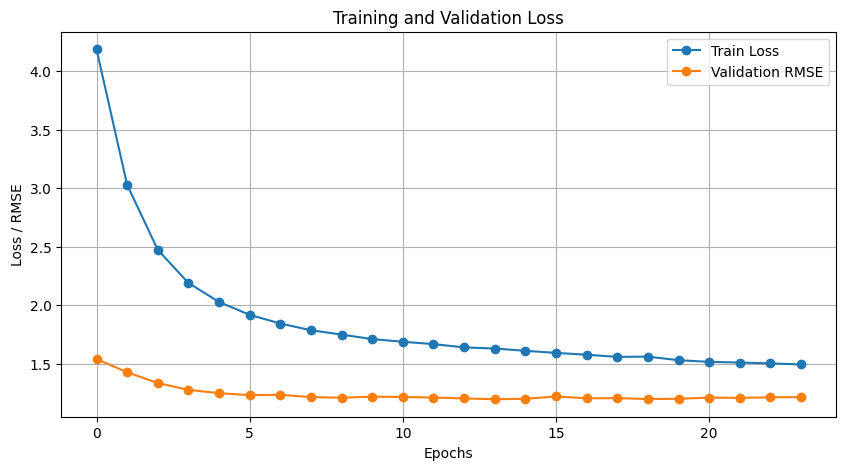

In [ ]:
import matplotlib.pyplot as plt

# 학습 완료 후 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_log, label='Train Loss', marker='o')
plt.plot(val_log, label='Validation RMSE', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss / RMSE')
plt.legend()
plt.grid(True)
plt.show()

#### Forecast

In [ ]:
model = BidirectionalModel()  # 모델 초기화
model.load_state_dict(torch.load('/LSTM_Bidirectional_model_1202.pth'))  # 저장된 가중치 로드

NameError: name 'BidirectionalModel' is not defined

In [ ]:
def inference_continuous(model, initial_df, forecast_steps, device):
    model.to(device)
    model.eval()

    # 초기 입력 데이터 설정 (예측을 시작할 시점의 데이터)
    predictions = []  # 예측 값을 저장할 리스트
    current_df = initial_df.copy()  # 초기 입력 데이터 복사

    for step in tqdm(range(forecast_steps)):
        # 입력 데이터를 준비 (X_RANGE만큼의 데이터)
        X = torch.Tensor(np.array(current_df.loc[-CFG['X_RANGE']:, ['YEAR', 'MONTH', 'DAY','HOUR',"ST_1171",	"ST_1172",	"ST_1173",	"ST_1174",	"ST_1178",	"ST_1179",	"ST_1180",	"ST_1181",	"ST_1182",	"ST_1184",	"ST_1185",	"ST_1186",	"ST_1245",	"ST_1246",	"ST_1247",	"ST_1248",	"ST_1364",	"ST_1365",	"ST_1407",	"ST_1433",	"ST_1559",	"ST_1561",	"ST_1562",	"ST_1566",	"ST_1568",	"ST_1571",	"ST_1573",	"ST_1574",	"ST_1575",	"ST_1576",	"ST_1577",	"ST_1578",	"ST_1679",	"ST_1703",	"ST_777",	"ST_779",	"ST_782",	"ST_783",	"ST_784",	"ST_786",	"ST_787",	"ST_788",	"ST_790",	"ST_791",	"ST_792",	"ST_793",	"ST_794",	"ST_795",	"ST_796",	"ST_798",	"ST_799",	"ST_801",	"ST_802",	"ST_804",	"ST_806",	"ST_807",	"ST_808",	"ST_809",	"ST_810",	"ST_811",	"ST_812",	"ST_813",	"ST_814",	"ST_815",	"ST_816",	"ST_817",	"ST_819",	"ST_820",	"ST_822",	"ST_823",	"ST_937",	"ST_953",	"ST_956",	"ST_957",	"ST_958",	"ST_959",	"ST_960",	"ST_961",	"ST_962",	"ST_963",	"ST_966",	"ST_1560",	"ST_2690",	"ST_2474",	"ST_2788",	"ST_2837",	"ST_2839",	"ST_2868",	"ST_2869",	"ST_2926",	"ST_3078",	"ST_3096",	"ST_3164",	"ST_3179",	"ST_3185",	"ST_2870",	"ST_2927",	"ST_3066",	"ST_3108",	"ST_3109",	"ST_3112",	"ST_3115",	"ST_3178",	"ST_3254",	"ST_1177",	"ST_2684",	"ST_2847",	"ST_2882",	"ST_3111",	"ST_3243",	"ST_3208",	"ST_3207",	"ST_1366",	"ST_1564",	"ST_1680",	"ST_1882",	"ST_1883",	"ST_1884",	"ST_1888",	"ST_1889",	"ST_1892",	"ST_1893",	"ST_1895",	"ST_1896",	"ST_1897",	"ST_2673",	"ST_2675",	"ST_2677",	"ST_2678",	"ST_2679",	"ST_2680",	"ST_2681",	"ST_2682",	"ST_2685",	"ST_2686",	"ST_2688",	"ST_2689",	"ST_2691",	"ST_2838",	"ST_2867",	"ST_2925",	"ST_3077",	"ST_3079",	"ST_3240",	"ST_3245",	"ST_3268",	"ST_789",	"ST_954",	"ST_1885",	"ST_2907",	"ST_1881",	"ST_2671",	"ST_818",	"ST_2674",	"ST_2676",	"ST_821",	"ST_1879",	"ST_1880",	"ST_1886",	"ST_1891",	"ST_797"]]).astype(float)).unsqueeze(0)
        X = X.to(device)

        # 모델을 사용하여 예측
        with torch.no_grad():
            model_pred = model(X)[0]

        # 예측 값을 처리하고 리스트에 추가
        model_pred = model_pred.cpu().numpy()
        predictions.append(model_pred)

        # 예측 결과를 새로운 입력으로 사용하기 위해 데이터 프레임에 추가
        new_row = current_df.iloc[-1].copy()  # 현재 마지막 행 복사
        new_row[['HOUR']] = new_row[['HOUR']] + 1 / 24  # 시간 증가

        # HOUR가 1 이상이면 DAY 증가
        if new_row['HOUR'] >= 1.0:
            new_row['HOUR'] -= 1.0
            new_row['DAY'] += 1 / 31.0  # 정규화된 값이므로 31일 기준으로 증가
            # DAY가 1 이상이면 MONTH 증가
            if new_row['DAY'] >= 1.0:
              new_row['DAY'] -= 1.0
              new_row['MONTH'] += 1 / 12.0  # 정규화된 값이므로 12개월 기준으로 증가

              # MONTH가 1 이상이면 YEAR 증가
              if new_row['MONTH'] >= 1.0:
                new_row['MONTH'] -= 1.0
                new_row['YEAR'] += 1 / 1000.0  # 정규화된 값이므로 1000년 기준으로 증가

        new_row[["ST_1171",	"ST_1172",	"ST_1173",	"ST_1174",	"ST_1178",	"ST_1179",	"ST_1180",	"ST_1181",	"ST_1182",	"ST_1184",	"ST_1185",	"ST_1186",	"ST_1245",	"ST_1246",	"ST_1247",	"ST_1248",	"ST_1364",	"ST_1365",	"ST_1407",	"ST_1433",	"ST_1559",	"ST_1561",	"ST_1562",	"ST_1566",	"ST_1568",	"ST_1571",	"ST_1573",	"ST_1574",	"ST_1575",	"ST_1576",	"ST_1577",	"ST_1578",	"ST_1679",	"ST_1703",	"ST_777",	"ST_779",	"ST_782",	"ST_783",	"ST_784",	"ST_786",	"ST_787",	"ST_788",	"ST_790",	"ST_791",	"ST_792",	"ST_793",	"ST_794",	"ST_795",	"ST_796",	"ST_798",	"ST_799",	"ST_801",	"ST_802",	"ST_804",	"ST_806",	"ST_807",	"ST_808",	"ST_809",	"ST_810",	"ST_811",	"ST_812",	"ST_813",	"ST_814",	"ST_815",	"ST_816",	"ST_817",	"ST_819",	"ST_820",	"ST_822",	"ST_823",	"ST_937",	"ST_953",	"ST_956",	"ST_957",	"ST_958",	"ST_959",	"ST_960",	"ST_961",	"ST_962",	"ST_963",	"ST_966",	"ST_1560",	"ST_2690",	"ST_2474",	"ST_2788",	"ST_2837",	"ST_2839",	"ST_2868",	"ST_2869",	"ST_2926",	"ST_3078",	"ST_3096",	"ST_3164",	"ST_3179",	"ST_3185",	"ST_2870",	"ST_2927",	"ST_3066",	"ST_3108",	"ST_3109",	"ST_3112",	"ST_3115",	"ST_3178",	"ST_3254",	"ST_1177",	"ST_2684",	"ST_2847",	"ST_2882",	"ST_3111",	"ST_3243",	"ST_3208",	"ST_3207",	"ST_1366",	"ST_1564",	"ST_1680",	"ST_1882",	"ST_1883",	"ST_1884",	"ST_1888",	"ST_1889",	"ST_1892",	"ST_1893",	"ST_1895",	"ST_1896",	"ST_1897",	"ST_2673",	"ST_2675",	"ST_2677",	"ST_2678",	"ST_2679",	"ST_2680",	"ST_2681",	"ST_2682",	"ST_2685",	"ST_2686",	"ST_2688",	"ST_2689",	"ST_2691",	"ST_2838",	"ST_2867",	"ST_2925",	"ST_3077",	"ST_3079",	"ST_3240",	"ST_3245",	"ST_3268",	"ST_789",	"ST_954",	"ST_1885",	"ST_2907",	"ST_1881",	"ST_2671",	"ST_818",	"ST_2674",	"ST_2676",	"ST_821",	"ST_1879",	"ST_1880",	"ST_1886",	"ST_1891",	"ST_797"]] = model_pred  # 예측된 값으로 업데이트

        # 새로운 행을 데이터 프레임에 추가
        current_df = pd.concat([current_df, new_row.to_frame().T], ignore_index=True)

    # 예측 결과를 데이터프레임으로 변환
    pred_df = pd.DataFrame(predictions, columns=["ST_1171",	"ST_1172",	"ST_1173",	"ST_1174",	"ST_1178",	"ST_1179",	"ST_1180",	"ST_1181",	"ST_1182",	"ST_1184",	"ST_1185",	"ST_1186",	"ST_1245",	"ST_1246",	"ST_1247",	"ST_1248",	"ST_1364",	"ST_1365",	"ST_1407",	"ST_1433",	"ST_1559",	"ST_1561",	"ST_1562",	"ST_1566",	"ST_1568",	"ST_1571",	"ST_1573",	"ST_1574",	"ST_1575",	"ST_1576",	"ST_1577",	"ST_1578",	"ST_1679",	"ST_1703",	"ST_777",	"ST_779",	"ST_782",	"ST_783",	"ST_784",	"ST_786",	"ST_787",	"ST_788",	"ST_790",	"ST_791",	"ST_792",	"ST_793",	"ST_794",	"ST_795",	"ST_796",	"ST_798",	"ST_799",	"ST_801",	"ST_802",	"ST_804",	"ST_806",	"ST_807",	"ST_808",	"ST_809",	"ST_810",	"ST_811",	"ST_812",	"ST_813",	"ST_814",	"ST_815",	"ST_816",	"ST_817",	"ST_819",	"ST_820",	"ST_822",	"ST_823",	"ST_937",	"ST_953",	"ST_956",	"ST_957",	"ST_958",	"ST_959",	"ST_960",	"ST_961",	"ST_962",	"ST_963",	"ST_966",	"ST_1560",	"ST_2690",	"ST_2474",	"ST_2788",	"ST_2837",	"ST_2839",	"ST_2868",	"ST_2869",	"ST_2926",	"ST_3078",	"ST_3096",	"ST_3164",	"ST_3179",	"ST_3185",	"ST_2870",	"ST_2927",	"ST_3066",	"ST_3108",	"ST_3109",	"ST_3112",	"ST_3115",	"ST_3178",	"ST_3254",	"ST_1177",	"ST_2684",	"ST_2847",	"ST_2882",	"ST_3111",	"ST_3243",	"ST_3208",	"ST_3207",	"ST_1366",	"ST_1564",	"ST_1680",	"ST_1882",	"ST_1883",	"ST_1884",	"ST_1888",	"ST_1889",	"ST_1892",	"ST_1893",	"ST_1895",	"ST_1896",	"ST_1897",	"ST_2673",	"ST_2675",	"ST_2677",	"ST_2678",	"ST_2679",	"ST_2680",	"ST_2681",	"ST_2682",	"ST_2685",	"ST_2686",	"ST_2688",	"ST_2689",	"ST_2691",	"ST_2838",	"ST_2867",	"ST_2925",	"ST_3077",	"ST_3079",	"ST_3240",	"ST_3245",	"ST_3268",	"ST_789",	"ST_954",	"ST_1885",	"ST_2907",	"ST_1881",	"ST_2671",	"ST_818",	"ST_2674",	"ST_2676",	"ST_821",	"ST_1879",	"ST_1880",	"ST_1886",	"ST_1891",	"ST_797"])

    return pred_df


In [ ]:
forecast_steps = 24

Cloud SQL에서 168hour_df 불러오기

In [ ]:
pip install sqlalchemy pymysql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
from sqlalchemy import create_engine,text
import pandas as pd

In [ ]:
# SQLAlchemy 엔진 생성
def create_sqlalchemy_engine():
    # Cloud SQL 연결 정보
    user = "root"  # MySQL 사용자 이름
    password = "0226"  # MySQL 비밀번호
    host = "34.70.111.107"  # Cloud SQL Public IP 주소
    port = "3306"  # MySQL 기본 포트
    database = "public_bike_database"  # 데이터베이스 이름

    # SQLAlchemy 엔진 생성
    engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")
    return engine

In [ ]:
# SQLAlchemy를 사용하여 데이터 가져오기
def fetch_data(engine, query):
    with engine.connect() as connection:
        result = connection.execute(query)
        # 쿼리 결과를 pandas 데이터프레임으로 변환
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
    return df

In [ ]:
# 실행 예제
if __name__ == "__main__":
    # SQLAlchemy 엔진 생성
    engine = create_sqlalchemy_engine()

    # 실행할 SQL 쿼리
    query = text("SELECT * FROM 2023_available_stocks LIMIT 10;")

    # 데이터 가져오기
    data = fetch_data(engine, query)
    print(data)

         Date  Time  stock  Rental_location_ID  Name_of_the_rental_location
0  0000-00-00     0    0.0  Rental_location_ID  Name_of_the_rental_location
1  2023-01-01     0    0.0             ST-1366                       크린랩 본사
2  2023-01-01     0    2.0              ST-798                      청담나들목입구
3  2023-01-01     0    1.0             ST-1246                    언주역 6번출구앞
4  2023-01-01     0    0.0              ST-820                   현대아파트 정문 앞
5  2023-01-01     0    0.0             ST-1895                 압구정로데오역 6번출구
6  2023-01-01     0    1.0              ST-793                     압구정파출소 앞
7  2023-01-01     0    5.0              ST-782                대모산입구역 2번출구 앞
8  2023-01-01     0    2.0             ST-3066                        신사스퀘어
9  2023-01-01     0    0.0              ST-789                       대현그린타워


In [ ]:
pred_df = inference_continuous(model, df_168hours, forecast_steps,device)

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
pred_df

,ST_1171,ST_1172,ST_1173,ST_1174,ST_1178,ST_1179,ST_1180,ST_1181,ST_1182,ST_1184,...,ST_2671,ST_818,ST_2674,ST_2676,ST_821,ST_1879,ST_1880,ST_1886,ST_1891,ST_797
0,0.470668,0.216061,0.206613,0.406642,0.467351,0.228262,0.178673,0.254995,0.367155,0.466240,...,0.009212,0.482783,0.240829,0.074250,0.288237,0.308251,0.437135,0.166114,0.083369,0.134709
1,0.302036,0.124303,0.187493,0.326573,0.227342,0.127677,0.147190,0.130544,0.193636,0.264684,...,-0.015364,0.259859,0.136080,0.035643,0.172187,0.127433,0.215038,0.143123,0.068036,0.160518
2,0.141328,0.075700,0.117644,0.246678,0.048476,0.076152,0.091380,0.072028,0.095566,0.105076,...,-0.031493,0.152683,0.071552,0.007048,0.126349,-0.000619,0.038549,0.098035,0.074196,0.165109
3,0.105889,0.062931,0.098529,0.225681,0.004569,0.067632,0.070489,0.071827,0.078407,0.087552,...,-0.038974,0.127584,0.057473,-0.011070,0.124746,-0.036222,0.004271,0.087950,0.071997,0.168147
4,0.109295,0.060402,0.104034,0.208999,0.016546,0.061573,0.068201,0.075357,0.080164,0.099928,...,-0.024927,0.137157,0.060895,-0.017906,0.142657,-0.029375,-0.003870,0.097185,0.070130,0.177682
5,0.096394,0.064285,0.112368,0.186002,0.039628,0.055761,0.070829,0.064476,0.078704,0.130728,...,0.010476,0.202552,0.081149,0.001020,0.199427,-0.007296,-0.019486,0.142873,0.064303,0.169995
6,0.098375,0.069719,0.111484,0.173653,0.063153,0.038061,0.084142,0.049278,0.085541,0.182573,...,0.061591,0.290112,0.112119,0.014153,0.288306,0.023076,-0.018930,0.205058,0.076362,0.169477
7,0.108437,0.068468,0.109954,0.164047,0.077837,0.033225,0.097452,0.045660,0.094048,0.232399,...,0.111767,0.362435,0.142121,0.034327,0.361352,0.053826,-0.007398,0.262026,0.085188,0.168811
8,0.122272,0.058731,0.123647,0.150480,0.082689,0.036196,0.106389,0.054686,0.103451,0.254804,...,0.154796,0.438675,0.157449,0.053285,0.402816,0.080753,0.035748,0.325656,0.099769,0.180671
9,0.137005,0.060163,0.148513,0.129033,0.091894,0.051607,0.115374,0.079870,0.130142,0.287650,...,0.192698,0.515738,0.167446,0.071509,0.464035,0.114213,0.112582,0.378691,0.110586,0.201902
